In [1]:
import os
import torch

In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

In [3]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7


In [6]:
data  =dataset[0]
print(data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [7]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training = self.training)
        x = self.conv2(x, edge_index)
        return x


In [8]:
model = GCN(hidden_channels=16) # Đổi 128, 256, ...
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [9]:
# Chua train, ve vissualize xem model no ngoc nhu nao
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

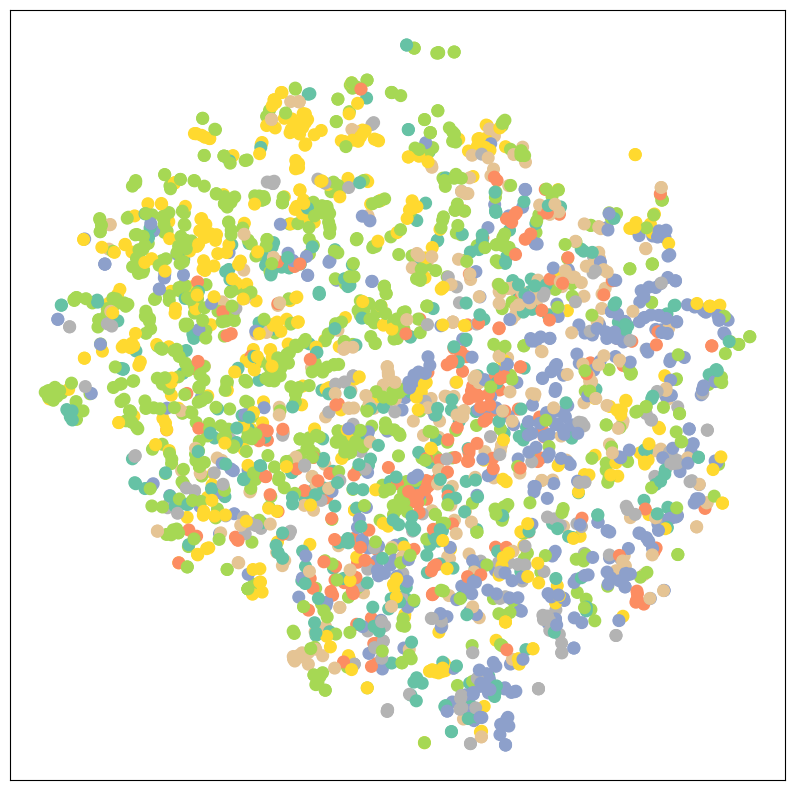

In [10]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [12]:
model = GCN(hidden_channels=16)
opt = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay = 5e-4)
cr = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    opt.zero_grad()
    out = model(data.x, data.edge_index)
    loss = cr(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    opt.step()
    return loss

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc


In [13]:
# Train
n_epochs = 100
for epoch in range(1, n_epochs+1):
    loss =train()
    print("Epoch {}. Loss = {}".format(epoch, loss))

Epoch 1. Loss = 1.9465153217315674
Epoch 2. Loss = 1.9416000843048096
Epoch 3. Loss = 1.9372421503067017
Epoch 4. Loss = 1.9338476657867432
Epoch 5. Loss = 1.925909161567688
Epoch 6. Loss = 1.920407772064209
Epoch 7. Loss = 1.9111396074295044
Epoch 8. Loss = 1.8988970518112183
Epoch 9. Loss = 1.8914448022842407
Epoch 10. Loss = 1.887452244758606
Epoch 11. Loss = 1.8697885274887085
Epoch 12. Loss = 1.862847924232483
Epoch 13. Loss = 1.8564497232437134
Epoch 14. Loss = 1.8480255603790283
Epoch 15. Loss = 1.8252160549163818
Epoch 16. Loss = 1.8111106157302856
Epoch 17. Loss = 1.8017404079437256
Epoch 18. Loss = 1.7939915657043457
Epoch 19. Loss = 1.7753286361694336
Epoch 20. Loss = 1.7624433040618896
Epoch 21. Loss = 1.7350040674209595
Epoch 22. Loss = 1.7375973463058472
Epoch 23. Loss = 1.7279516458511353
Epoch 24. Loss = 1.6999294757843018
Epoch 25. Loss = 1.6717313528060913
Epoch 26. Loss = 1.6594829559326172
Epoch 27. Loss = 1.642482876777649
Epoch 28. Loss = 1.6406090259552002
Epoch 

In [15]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')


Test Accuracy: 0.8090


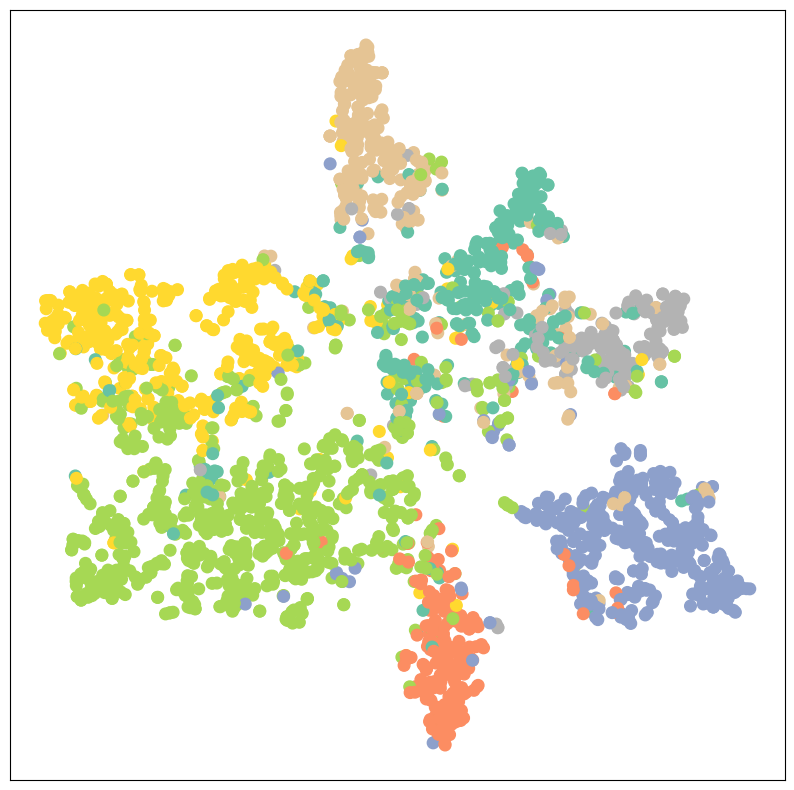

In [16]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [21]:
print(data.y[10], out[10].argmax())

tensor(0) tensor(0)
